# <font color='darkred'> Clustering sur les épisodes

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.feature_extraction import stop_words
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import math
from scipy import sparse

In [182]:
import os
import re
import nltk
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer

def verifier_ligne(ligne):
    """return True si la ligne est un sous-titre, False sinon"""
    timestamp_regex = r'[0-9]{2}:[0-9]{2}:[0-9]{2}' 
    subnumber_regex =r'^[0-9]+$'
    
    liste_regex = [timestamp_regex, subnumber_regex]

    l = ligne.lower()
    if "addic7ed" in l:
        return False
    #if l.startswith("sync"):
        #return False
    for regex in liste_regex:
        if re.match(regex, ligne):
            return False
    return True

def transformer_ligne(ligne):
    """str -> str
    effectue transformation souhaitees sur la ligne"""
    tag_regex = r'<(/)*[a-zA-Z]+>' #to get rif of tags
    alphanum_regex = r'\W+'  #get rid of non alphanumeric characters
    new_line = re.sub(tag_regex, '', ligne)
    new_line = re.sub(r'\W+', ' ', new_line)
    return new_line

def scan_folder(parent_folder, corp):
    """retourne corpus des textes contenus dans parent_folder sous forme de liste de string"""
    # iterate over all the files in directory 'parent_folder'

    for file_name in sorted(os.listdir(parent_folder)):
        if file_name.endswith(".txt"):
            path = parent_folder+"/"+file_name
            fichier = open(path, "r", encoding = "ISO-8859-1")
            lignes = fichier.readlines()
            fichier.close()
            
            texte = ""
            for ligne in lignes :
                #ligne = ligne.lower()
                if verifier_ligne(ligne):
                    new_line = transformer_ligne(ligne)
                    texte += new_line
            corp.append(texte)
        
        else:
            current_path = "".join((parent_folder, "/", file_name))
            if os.path.isdir(current_path):
                # if we're checking a sub-directory, recall this method
                scan_folder(current_path, corp)
    
    return corp


#pour eviter les variables globales utiliser get_corpus qui appelle scan_folder
def get_corpus(parent_folder):
    """retourne corpus des textes contenus dans parent_folder sous forme de liste de string"""
    c = []
    res = scan_folder(parent_folder, c)
    return res

def stemming_tokenizer(str_input):
    blob = TextBlob(str_input.lower())
    tokens = blob.words
    words = [token.stem() for token in tokens]
    return words

def lemmatizing_tokenizer(str_input):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(str_input)
    words = [lemmatizer.lemmatize(word, pos="v") for word in tokens]
    return words

def lemmatizing_tokenizer_v2(str_input):
    words = []
    wnl = WordNetLemmatizer()
    tokens_tagged =pos_tag(word_tokenize(str_input))
    for word, tag in tokens_tagged:
        if tag.startswith("NN"):
            word = wnl.lemmatize(word, pos='n')
        elif tag.startswith('VB'):
            word = wnl.lemmatize(word, pos='v')
        elif tag.startswith('JJ'):
            word = wnl.lemmatize(word, pos='a')
        else:
            pass
        words.append(word)

    return words

In [183]:
c = get_corpus("/Vrac/PLDAC_addic7ed/data/1___Lost/05")

### <font color='darkgreen'> Ensemble de stopwords

In [80]:
path = "/users/Etu6/3520166/PLDAC_Recommandation_analyse_sous_titres-master/ressources/stopwords.txt"
fichier = open(path, "r")
lignes = fichier.readlines()
fichier.close()
stopwords_set = set()
for l in lignes :
    l = l.rstrip('\n')
    stopwords_set.add(l)
len(stopwords_set)

436

## <font color='darkblue'> Clustering par saison

On veut voir si l'algo des kMeans est capable de différencier les épisodes de la saison 1 d'Avatar de la saison 2 de la même série en se basant sur les tf-idf des mots par rapport aux deux saisons.

On réalise deux corpus composés des deux saisons afin de calculer séparement les tf-idf des mots par saison (sinon, c'est beaucoup plus facile de différencier des épisodes).

In [81]:
# formation du corpus 
path_serie1 = "/Vrac/PLDAC_addic7ed/data/175___Avatar__The_Last_Airbender/01"
path_serie2 = "/Vrac/PLDAC_addic7ed/data/175___Avatar__The_Last_Airbender/02"

corpus1 = get_corpus(path_serie1)
corpus2 = get_corpus(path_serie2)

corpus = corpus1 + corpus2

# ensemble de stopwords = stopwords_set

In [82]:
vectorizer = TfidfVectorizer(stop_words = stopwords_set)
X1 = vectorizer.fit_transform(corpus1)
voc1 = vectorizer.get_feature_names()
dense1 = X1.todense()
denselist1 = dense1.tolist()
df_tfidf1 = pd.DataFrame(denselist1, columns=voc1)

vectorizer = TfidfVectorizer(stop_words = stopwords_set)
X2 = vectorizer.fit_transform(corpus2)
voc2 = vectorizer.get_feature_names()
dense2 = X2.todense()
denselist2 = dense2.tolist()
df_tfidf2 = pd.DataFrame(denselist2, columns=voc2)

In [83]:
frames = [df_tfidf1, df_tfidf2]
df_tfidf = pd.concat(frames, sort=True)
df_tfidf = df_tfidf.fillna(0)

In [87]:
# labels corrects pour calculer l'accuracy
# 1 = saison 1
# 0 = saison 2

y = []
for i in range(0, 21) :
    y.append(1)
for i in range(0, 20) :
    y.append(0)
len(y)

41

In [85]:
matrix_tfidf = df_tfidf.values
# pour la transformer en sparse matrix
sparse_matrix_tfidf = sparse.csr_matrix(matrix_tfidf)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(sparse_matrix_tfidf)
labels = kmeans.labels_

In [86]:
for i in range(0, len(labels)) :
    print("Épisode "+str(i)+" classé dans le groupe : "+str(labels[i]))

Épisode 0 classé dans le groupe : 1
Épisode 1 classé dans le groupe : 1
Épisode 2 classé dans le groupe : 1
Épisode 3 classé dans le groupe : 1
Épisode 4 classé dans le groupe : 1
Épisode 5 classé dans le groupe : 1
Épisode 6 classé dans le groupe : 1
Épisode 7 classé dans le groupe : 1
Épisode 8 classé dans le groupe : 1
Épisode 9 classé dans le groupe : 1
Épisode 10 classé dans le groupe : 1
Épisode 11 classé dans le groupe : 1
Épisode 12 classé dans le groupe : 1
Épisode 13 classé dans le groupe : 1
Épisode 14 classé dans le groupe : 1
Épisode 15 classé dans le groupe : 0
Épisode 16 classé dans le groupe : 1
Épisode 17 classé dans le groupe : 1
Épisode 18 classé dans le groupe : 1
Épisode 19 classé dans le groupe : 1
Épisode 20 classé dans le groupe : 1
Épisode 21 classé dans le groupe : 0
Épisode 22 classé dans le groupe : 0
Épisode 23 classé dans le groupe : 1
Épisode 24 classé dans le groupe : 0
Épisode 25 classé dans le groupe : 0
Épisode 26 classé dans le groupe : 0
Épisode 27 

In [88]:
cpt = 0
for i in range(0, len(labels)) :
    if y[i] == labels[i] :
        cpt += 1
print("Accuracy = "+str(cpt/len(labels)))

Accuracy = 0.8048780487804879


Pour cet exemple, l'accuracy est bonne.

## <font color='darkblue'> Clustering par série

On veut voir la même chose qu'avant mais cette fois-ci entre les épisodes de deux séries différentes.

### <font color='darkgreen'> Séries très différentes

Premiers tests sur deux séries très différentes :
- Lost
- Avatar

On s'attend à de bons résultats : le vocabulaire employé dans les deux séries est très différent.

In [89]:
# formation du corpus 
path_serie1 = "/Vrac/PLDAC_addic7ed/data/175___Avatar__The_Last_Airbender/01"
path_serie2 = "/Vrac/PLDAC_addic7ed/data/1___Lost/01"

corpus1 = get_corpus(path_serie1)
corpus2 = get_corpus(path_serie2)

corpus = corpus1 + corpus2

# ensemble de stopwords = stopwords_set

In [90]:
vectorizer = TfidfVectorizer(stop_words = stopwords_set)
X1 = vectorizer.fit_transform(corpus1)
voc1 = vectorizer.get_feature_names()
dense1 = X1.todense()
denselist1 = dense1.tolist()
df_tfidf1 = pd.DataFrame(denselist1, columns=voc1)

vectorizer = TfidfVectorizer(stop_words = stopwords_set)
X2 = vectorizer.fit_transform(corpus2)
voc2 = vectorizer.get_feature_names()
dense2 = X2.todense()
denselist2 = dense2.tolist()
df_tfidf2 = pd.DataFrame(denselist2, columns=voc2)

In [91]:
frames = [df_tfidf1, df_tfidf2]
df_tfidf = pd.concat(frames, sort=True)
df_tfidf = df_tfidf.fillna(0)

In [92]:
matrix_tfidf = df_tfidf.values
# pour la transformer en sparse matrix
sparse_matrix_tfidf = sparse.csr_matrix(matrix_tfidf)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(sparse_matrix_tfidf)
labels = kmeans.labels_

In [93]:
for i in range(0, len(labels)) :
    print("Épisode "+str(i)+" classé dans le groupe : "+str(labels[i]))

Épisode 0 classé dans le groupe : 0
Épisode 1 classé dans le groupe : 0
Épisode 2 classé dans le groupe : 0
Épisode 3 classé dans le groupe : 0
Épisode 4 classé dans le groupe : 0
Épisode 5 classé dans le groupe : 0
Épisode 6 classé dans le groupe : 0
Épisode 7 classé dans le groupe : 0
Épisode 8 classé dans le groupe : 0
Épisode 9 classé dans le groupe : 0
Épisode 10 classé dans le groupe : 0
Épisode 11 classé dans le groupe : 0
Épisode 12 classé dans le groupe : 0
Épisode 13 classé dans le groupe : 0
Épisode 14 classé dans le groupe : 0
Épisode 15 classé dans le groupe : 0
Épisode 16 classé dans le groupe : 0
Épisode 17 classé dans le groupe : 0
Épisode 18 classé dans le groupe : 0
Épisode 19 classé dans le groupe : 0
Épisode 20 classé dans le groupe : 0
Épisode 21 classé dans le groupe : 1
Épisode 22 classé dans le groupe : 1
Épisode 23 classé dans le groupe : 1
Épisode 24 classé dans le groupe : 1
Épisode 25 classé dans le groupe : 1
Épisode 26 classé dans le groupe : 1
Épisode 27 

In [94]:
y = []
for i in range(0, len(corpus1)) :
    y.append(0)
for i in range(0, len(corpus2)) :
    y.append(1)
len(y)

45

In [95]:
cpt = 0
for i in range(0, len(labels)) :
    if y[i] == labels[i] :
        cpt += 1
print("Accuracy = "+str(cpt/len(labels)))

Accuracy = 1.0


Pour ces deux séries, classification parfaite.

### <font color='darkgreen'> Séries très similaires

On s'intéresse maintenant à deux séries avec un vocabulaire plus similaire.
- Dr House
- Grey's Anatomy



In [96]:
# formation du corpus 
path_serie1 ="/Vrac/PLDAC_addic7ed/data/30___Grey_s_Anatomy/01"
path_serie2 = "/Vrac/PLDAC_addic7ed/addic7ed/15___House/01"

corpus1 = get_corpus(path_serie1)
corpus2 = get_corpus(path_serie2)

corpus = corpus1 + corpus2

# ensemble de stopwords = stopwords_set

In [97]:
vectorizer = TfidfVectorizer(stop_words = stopwords_set)
X1 = vectorizer.fit_transform(corpus1)
voc1 = vectorizer.get_feature_names()
dense1 = X1.todense()
denselist1 = dense1.tolist()
df_tfidf1 = pd.DataFrame(denselist1, columns=voc1)

vectorizer = TfidfVectorizer(stop_words = stopwords_set)
X2 = vectorizer.fit_transform(corpus2)
voc2 = vectorizer.get_feature_names()
dense2 = X2.todense()
denselist2 = dense2.tolist()
df_tfidf2 = pd.DataFrame(denselist2, columns=voc2)

In [98]:
frames = [df_tfidf1, df_tfidf2]
df_tfidf = pd.concat(frames, sort=True)
df_tfidf = df_tfidf.fillna(0)

In [99]:
matrix_tfidf = df_tfidf.values
# pour la transformer en sparse matrix
sparse_matrix_tfidf = sparse.csr_matrix(matrix_tfidf)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(sparse_matrix_tfidf)
labels = kmeans.labels_
len(labels)

31

In [101]:
for i in range(0, len(labels)) :
    print("Épisode "+str(i)+" classé dans le groupe : "+str(labels[i]))

Épisode 0 classé dans le groupe : 0
Épisode 1 classé dans le groupe : 0
Épisode 2 classé dans le groupe : 0
Épisode 3 classé dans le groupe : 0
Épisode 4 classé dans le groupe : 0
Épisode 5 classé dans le groupe : 1
Épisode 6 classé dans le groupe : 0
Épisode 7 classé dans le groupe : 0
Épisode 8 classé dans le groupe : 1
Épisode 9 classé dans le groupe : 1
Épisode 10 classé dans le groupe : 1
Épisode 11 classé dans le groupe : 1
Épisode 12 classé dans le groupe : 1
Épisode 13 classé dans le groupe : 1
Épisode 14 classé dans le groupe : 1
Épisode 15 classé dans le groupe : 1
Épisode 16 classé dans le groupe : 1
Épisode 17 classé dans le groupe : 1
Épisode 18 classé dans le groupe : 1
Épisode 19 classé dans le groupe : 1
Épisode 20 classé dans le groupe : 1
Épisode 21 classé dans le groupe : 1
Épisode 22 classé dans le groupe : 1
Épisode 23 classé dans le groupe : 1
Épisode 24 classé dans le groupe : 1
Épisode 25 classé dans le groupe : 1
Épisode 26 classé dans le groupe : 1
Épisode 27 

In [102]:
y = []
for i in range(0, len(corpus1)) :
    y.append(0)
for i in range(0, len(corpus2)) :
    y.append(1)
len(y)

31

In [103]:
cpt = 0
for i in range(0, len(labels)) :
    if y[i] == labels[i] :
        cpt += 1
print("Accuracy = "+str(cpt/len(labels)))

Accuracy = 0.9354838709677419


Ici, les deux séries utilisent un vocabulaire similaire (vocabulaire médical en plus) ce qui peut expliquer la petite baisse en accuracy. 

## <font color='darkblue'> Problèmes des noms propres

Afin de pimenter un peu la classification, on va essayer d'enlever les noms propres, qui sont très discriminants pour différencier deux épisodes de séries différentes.

In [104]:
# formation du corpus 
path_serie1 ="/Vrac/PLDAC_addic7ed/data/30___Grey_s_Anatomy/01"
path_serie2 = "/Vrac/PLDAC_addic7ed/addic7ed/15___House/01"

corpus1 = get_corpus(path_serie1)
corpus2 = get_corpus(path_serie2)

corpus = corpus1 + corpus2

# ensemble de stopwords = stopwords_set

In [106]:
vectorizer = TfidfVectorizer(stop_words = stopwords_set)
X1 = vectorizer.fit_transform(corpus1)
voc1 = vectorizer.get_feature_names()
dense1 = X1.todense()
denselist1 = dense1.tolist()
df_tfidf1 = pd.DataFrame(denselist1, columns=voc1)

vectorizer = TfidfVectorizer(stop_words = stopwords_set)
X2 = vectorizer.fit_transform(corpus2)
voc2 = vectorizer.get_feature_names()
dense2 = X2.todense()
denselist2 = dense2.tolist()
df_tfidf2 = pd.DataFrame(denselist2, columns=voc2)

In [107]:
frames = [df_tfidf1, df_tfidf2]
df_tfidf = pd.concat(frames, sort=True)
df_tfidf = df_tfidf.fillna(0)

In [108]:
nlargest = 20
order = np.argsort(-df_tfidf.values, axis=1)[:, :nlargest]
result = pd.DataFrame(df_tfidf.columns[order], 
                      columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                      index=df_tfidf.index)
result.tail()

,top1,top2,top3,top4,top5,top6,top7,top8,top9,top10,top11,top12,top13,top14,top15,top16,top17,top18,top19,top20
17,james,twitch,tuberculoma,whoah,wrist,victoria,pin,mri,homeless,fury,meningitis,foreman,prozac,terharg,streets,cancer,treatment,doesn,sorry,105
18,mark,alzheimer,attack,stacy,yoga,paris,blah,aip,mountain,encephalitis,gregg,warner,gonna,doesn,house,time,bladder,paranoia,friends,guy
19,meningitis,rash,form,mary,neck,blue,bleeding,ow,blood,interview,interviewing,brenda,lumbar,puncture,stomach,fine,people,asian,pool,shoes
20,mom,dvt,schizophrenia,vitamin,luke,gonna,birthday,meds,dr,blood,ampicillin,schizophrenic,pt,pickles,tumor,alcohol,crazy,services,praise,shrink
21,matt,chi,hydrolase,davis,kid,poisoned,time,son,mom,tomato,cdc,clothes,poison,pesticides,washed,bus,gonna,detergent,pesticide,disulfoton


On voit que les tf-idf les plus élevés sont très souvent des noms propres.

Le but va être de les éliminer pour chaque épisode afin de voir si les kMeans peuvent différencier sur autre chose.

Dans un premier temps, on enlève, pour chaque épisode, les 20 mots dont les tf-idf sont les plus grands. C'est peut-être un peu trop, on ajustera après.

Il faut soit remplacer le tf-idf de ces mots par autre chose ou bien les enlever du vocabulaire pour tous les épisodes.
- remplacer : par un 0 ? un nombre aléatoire ? autre chose ?
        -> on veut que ces mots ne soient plus discriminants pour la classification
- enlever : on récupère pour chaque épisode les 20 mots avec les plus grands tf-idf et on crée un ensemble puis on enlève tous ces mots dans tous les épisodes 

### <font color='darkgreen'> Élimination du dataFrame

On récupère pour chaque épisode les 20 mots avec les plus grands tf-idf et on crée un ensemble puis on enlève tous ces mots dans tous les épisodes.

In [109]:
noms = result.values
set_noms_propres = set()
for ep in noms :
    for mot in ep :
        set_noms_propres.add(mot)
liste_noms_propres = list(set_noms_propres)
len(liste_noms_propres)

471

In [110]:
df_tfidf.head()

,00,000,007,00am,03,10,100,100l65,100mg,101,...,yummy,yup,zebra,zebras,zero,zeros,zit,zits,zoo,ªclickâ
0,0.000000,0.000000,0.00000,0.000000,0.0,0.012173,0.000000,0.021025,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.069274,0.000000,0.00000,0.017794,0.0,0.020605,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.017794,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.015689,0.15689,0.000000,0.0,0.010755,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.014648,0.000000,0.00000,0.000000,0.0,0.000000,0.076272,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.063004,0.000000,0.00000,0.000000,0.0,0.000000,0.098415,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
# pour se débarasser des colonnes
df_copy = df_tfidf.copy()

for mot in liste_noms_propres :
    df_copy = df_copy.drop(mot, axis=1)
    
df_copy.head()

,00,000,00am,03,10,100l65,100mg,101,102,103,...,yummy,yup,zebra,zebras,zero,zeros,zit,zits,zoo,ªclickâ
0,0.000000,0.000000,0.000000,0.0,0.012173,0.021025,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.069274,0.000000,0.017794,0.0,0.020605,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.017794,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.015689,0.000000,0.0,0.010755,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.014648,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.063004,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
vectorizer = TfidfVectorizer(stop_words = stopwords_set)
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
dico = vectorizer.get_feature_names()
dense = X.todense()
denselist = dense.tolist()
df_tfidf = pd.DataFrame(denselist, columns=feature_names)

In [149]:
matrix_tfidf = df_copy.values
# pour la transformer en sparse matrix
sparse_matrix_tfidf = sparse.csr_matrix(matrix_tfidf)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(sparse_matrix_tfidf)
labels = kmeans.labels_
len(labels)

31

In [114]:
for i in range(0, len(labels)) :
    print("Épisode "+str(i)+" classé dans le groupe : "+str(labels[i]))

Épisode 0 classé dans le groupe : 0
Épisode 1 classé dans le groupe : 0
Épisode 2 classé dans le groupe : 0
Épisode 3 classé dans le groupe : 0
Épisode 4 classé dans le groupe : 0
Épisode 5 classé dans le groupe : 0
Épisode 6 classé dans le groupe : 0
Épisode 7 classé dans le groupe : 0
Épisode 8 classé dans le groupe : 0
Épisode 9 classé dans le groupe : 0
Épisode 10 classé dans le groupe : 0
Épisode 11 classé dans le groupe : 0
Épisode 12 classé dans le groupe : 0
Épisode 13 classé dans le groupe : 0
Épisode 14 classé dans le groupe : 0
Épisode 15 classé dans le groupe : 0
Épisode 16 classé dans le groupe : 0
Épisode 17 classé dans le groupe : 0
Épisode 18 classé dans le groupe : 0
Épisode 19 classé dans le groupe : 0
Épisode 20 classé dans le groupe : 0
Épisode 21 classé dans le groupe : 0
Épisode 22 classé dans le groupe : 0
Épisode 23 classé dans le groupe : 0
Épisode 24 classé dans le groupe : 0
Épisode 25 classé dans le groupe : 0
Épisode 26 classé dans le groupe : 0
Épisode 27 

In [144]:
y = []
for i in range(0, len(corpus1)) :
    y.append(1)
for i in range(0, len(corpus2)) :
    y.append(0)
len(y)

31

In [145]:
cpt = 0
for i in range(0, len(labels)) :
    if y[i] == labels[i] :
        cpt += 1
print("Accuracy = "+str(cpt/len(labels)))

Accuracy = 0.6774193548387096


Accuracy assez mauvaise, dans les affectations, on peut voir que tous les épisodes sauf un sont classés dans le groupe 0.

## <font color='darkblue'> Des petites fonctions propres

In [118]:
def accuracy(labels, y) :
    """
    labels : labels prédis 
    y : labels corrects
    renvoie l'accuracy
    """

    cpt = 0
    for i in range(0, len(labels)) :
        if y[i] == labels[i] :
            cpt += 1
    
    return cpt/len(labels)

In [131]:
def retirer_n_premiers(n, df_tfidf) :

    nlargest = n
    order = np.argsort(-df_tfidf.values, axis=1)[:, :nlargest]
    result = pd.DataFrame(df_tfidf.columns[order], 
                          columns=['top{}'.format(i) for i in range(1, nlargest+1)],
                          index=df_tfidf.index)


    noms = result.values
    set_noms_propres = set()
    for ep in noms :
        for mot in ep :
            set_noms_propres.add(mot)
    liste_noms_propres = list(set_noms_propres)
    len(liste_noms_propres)

    # pour se débarasser des colonnes
    df_copy = df_tfidf.copy()

    for mot in liste_noms_propres :
        df_copy = df_copy.drop(mot, axis=1)

    
    return df_copy

In [187]:
def calcul_labels_corrects(corpus1, corpus2, labels) :
    
    y = []
    for i in range(0, len(corpus1)) :
        y.append(1)
    for i in range(0, len(corpus2)) :
        y.append(0)
    
    return y

In [188]:
def classif_deux_series(path_serie1, path_serie2, stopwords_set, n=0) :
    """
    pour classifier deux séries
    on enlève les n plus grands tf-idf
    """
    corpus1 = get_corpus(path_serie1)
    corpus2 = get_corpus(path_serie2)
    corpus = corpus1 + corpus2
    
    
    vectorizer = TfidfVectorizer(stop_words = stopwords_set)
    X1 = vectorizer.fit_transform(corpus1)
    voc1 = vectorizer.get_feature_names()
    dense1 = X1.todense()
    denselist1 = dense1.tolist()
    df_tfidf1 = pd.DataFrame(denselist1, columns=voc1)

    vectorizer = TfidfVectorizer(stop_words = stopwords_set)
    X2 = vectorizer.fit_transform(corpus2)
    voc2 = vectorizer.get_feature_names()
    dense2 = X2.todense()
    denselist2 = dense2.tolist()
    df_tfidf2 = pd.DataFrame(denselist2, columns=voc2)
    
    frames = [df_tfidf1, df_tfidf2]
    df_tfidf = pd.concat(frames, sort=True)
    df_tfidf = df_tfidf.fillna(0)
    
    if(n != 0) :
        df_tfidf = retirer_n_premiers(n, df_tfidf)
    
    matrix_tfidf = df_tfidf.values
    # pour la transformer en sparse matrix
    sparse_matrix_tfidf = sparse.csr_matrix(matrix_tfidf)
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=2, random_state=0, n_jobs=-1).fit(sparse_matrix_tfidf)
    
    labels = kmeans.labels_
    
    y = calcul_labels_corrects(corpus1, corpus2, labels)
    
    return labels, y

In [189]:
path_serie1 = "/Vrac/PLDAC_addic7ed/data/175___Avatar__The_Last_Airbender/01"
path_serie2 = "/Vrac/PLDAC_addic7ed/data/175___Avatar__The_Last_Airbender/02"

l, y = classif_deux_series(path_serie1, path_serie2, stopwords_set)
accuracy(l, y)

0.6829268292682927

In [153]:
import matplotlib.pyplot as plt

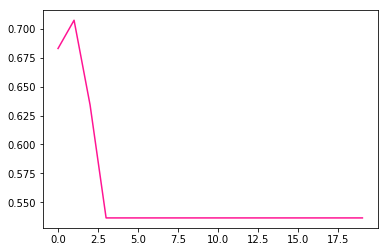

In [190]:
n = 20
x = range(0, n)
acc = []
for i in x :
    l, y = classif_deux_series(path_serie1, path_serie2, stopwords_set, i)
    acc.append(accuracy(l, y))

plt.plot(x, acc, color='deeppink')